# Erasing a memory from a conditional variational autoencoder

The network is trained on MNIST data. The goal is to make the network to "forget" the correct classification for objects of certain class. In this notebook, the trained generative network is based on variational autoencoder (vae).

In **this version**, the classifier produces sparse activity at its output

In [1]:
import os
# Disable GPU in a case of kernel freezing
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
from keras.layers import Lambda, Input, Dense, concatenate
from keras.models import Model
from keras.optimizers import SGD
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy, categorical_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.utils import to_categorical
from keras import regularizers

import numpy as np
import matplotlib.pyplot as plt
import copy

# needed for confusion matrix plot
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [3]:
# dictionary of transformations
activity = {0: [1,1,0,0,0],
            1: [1,0,1,0,0],
            2: [1,0,0,1,0],
            3: [1,0,0,0,1],
            4: [0,1,1,0,0],
            5: [0,1,0,1,0],
            6: [0,1,0,0,1],
            7: [0,0,1,1,0],
            8: [0,0,1,0,1],
            9: [0,0,0,1,1]}

# convert output labels to sparse representation
def to_sparse(y):
    y_sparse = np.zeros((y.shape[0],5)) # output sparse activities
    for c in range(10): 
        y_sparse[y==c,:] = activity[c]
    return y_sparse

# convert sparse representations back to labels
def to_labels(y_sparse):
    y_sparse = np.round(y_sparse).astype(int) # convert to zeros and ones
    y = np.ones(y_sparse.shape[0]) # output labels
    y *= 10 # 10 corresponds to unrecognised category
    for c in range(10):
        tmp = np.absolute(y_sparse-activity[c])
        ind = np.sum(tmp,axis=-1)==0
        y[ind] = c
    return y

In [4]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
X_train = np.reshape(x_train, [-1, original_dim])
X_test = np.reshape(x_test, [-1, original_dim])
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

Y_train = to_sparse(y_train)
Y_test = to_sparse(y_test)

In [5]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 400
batch_size = 32
latent_dim = 8
epochs = 20
nb_class = 5 # number of outputs in classifier
l2 = 1e-4 # L2 regularization

In [6]:
# Pick random class to forget
forget_ind = np.random.choice(10)
print(forget_ind)

6


Define some functions

In [7]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

Construct CVAE

In [8]:
# CVAE model = encoder + decoder + classifier

# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu',kernel_regularizer=regularizers.l2(l2))(inputs)
x = Dense(intermediate_dim, activation='relu',kernel_regularizer=regularizers.l2(l2))(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

#build classifier model
classifier_outputs = Dense(nb_class, activation='sigmoid',kernel_regularizer=regularizers.l2(l2))(x)

# instantiate classifier model
digit_classifier = Model(inputs, classifier_outputs, name='classifier')

# build decoder model
latent_inputs = Input(shape=(latent_dim+nb_class,), name='conditional_z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
x = Dense(intermediate_dim, activation='relu')(x)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
z_cond = concatenate(inputs=[encoder(inputs)[2], digit_classifier(inputs)])
outputs = decoder(z_cond)
vae = Model(inputs, outputs, name='cvae')

In [9]:
# Define multi-task loss function
def loss(y_true,y_pred):
    reconstruction_loss = binary_crossentropy(inputs,outputs)
    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    classification_loss = binary_crossentropy(y_true,classifier_outputs)
    classification_loss *= nb_class*10 # improve classification by increasing the contribution of loss
    return K.mean(reconstruction_loss + kl_loss + classification_loss)

# Define custom accuracy
def class_acc(y_true,y_pred):
    return K.equal(K.mean(K.equal(y_true, K.round(classifier_outputs)), axis=-1),1)

vae.compile(optimizer='adam', loss=loss, metrics=[class_acc])

## Initial training of network

In [10]:
vae.fit(X_train,Y_train,epochs=epochs,batch_size=batch_size,verbose=0)
vae.save_weights('cvae_weights_sparse_ini.h5') # save weights for further use

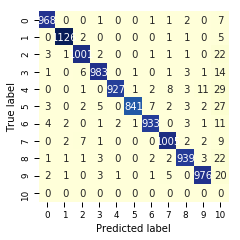

In [11]:
# plot initial confusion matrix
pred = digit_classifier.predict(X_test)
y_pred = to_labels(pred)
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(11),range(11))
plt.figure(figsize = (3.5,3.5))
sn.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":10})
ax = sn.heatmap(df_cm, vmin=0,vmax=1100,annot=True,cbar=False,fmt='2.0f',square=True,cmap='YlGnBu')
ax.set_xlabel('Predicted label')    
ax.set_ylabel('True label')
plt.savefig('Train_initial_sparse.pdf', format='pdf')
plt.show()

## Erase memory using initial dataset

In [ ]:
vae.load_weights("cvae_weights_sparse_ini.h5") # load initial weights
# modify labels
yf_train = copy.deepcopy(Y_train)
tmp = np.absolute(Y_train-activity[forget_ind])
ind = np.sum(tmp,axis=-1)==0 # indices for activities to modify
yf_train[ind,:] = np.zeros((np.count_nonzero(ind),nb_class)) # deactivate output

In [ ]:
# retrain the classifier of the cvae on modified data
#vae.fit(x_train,yf_train,epochs=epochs,batch_size=batch_size,verbose=0)
digit_classifier.compile(optimizer=SGD(lr=0.001),loss='binary_crossentropy',metrics=[class_acc])
digit_classifier.fit(X_train,yf_train,epochs=epochs,batch_size=batch_size,verbose=0)

In [ ]:
# plot confusion matrix
pred = digit_classifier.predict(X_test)
y_pred = to_labels(pred)
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(11),range(11))
plt.figure(figsize = (3.5,3.5))
sn.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":10})
ax = sn.heatmap(df_cm, vmin=0,vmax=1100,annot=True,cbar=False,fmt='2.0f',square=True,cmap='YlGnBu')
ax.set_xlabel('Predicted label')    
ax.set_ylabel('True label')
plt.savefig('Erase_initial_sparse.pdf', format='pdf')
plt.show()

In [ ]:
# estimate the quality of forgetting:
# The net should correctly classify all classes but one, and it should misclasify one class
indc = y_test!=forget_ind # indices for correct classification
indw = y_test==forget_ind # indices for misclassification
num_correct = np.sum(y_test[indc]==y_pred[indc]) # number of correct predictions for remembered classes
num_wrong = np.sum(y_test[indw]!=y_pred[indw]) # number of wrong predictions for forgotten class
forget_accuracy = (num_correct+num_wrong)/y_test.size # accuracy of forgetting
print("Quality of forgetting:", forget_accuracy)

## Erase memory using samples generated by CVAE

In [10]:
vae.load_weights("cvae_weights_sparse_ini.h5") # restore initial weights

Generate artificial samples of the same amount as initial training samples

In [11]:
dreams = np.empty(shape=[0, original_dim]) # array to store samples
y_gen = np.empty(shape=[0, nb_class]) # target vectors
for _ in range(X_train.shape[0] // batch_size): # generate dreams in batches
    y_batch = np.random.randint(10, size=batch_size)
    y_batch = to_sparse(y_batch) # generate random target vectors
    y_gen = np.append(y_gen, y_batch, axis=0)
    z_sample = np.random.randn(batch_size,latent_dim) # sampling latent vector
    z_cond = np.concatenate((z_sample,y_batch), axis=1)
    dream_batch = decoder.predict(z_cond) # generate corresponding dreams
    dreams = np.append(dreams, dream_batch, axis=0) # add dreams to the collection

In [12]:
# modify labels for generated dreams
yf_gen = copy.deepcopy(y_gen)
tmp = np.absolute(y_gen-activity[forget_ind])
ind = np.sum(tmp,axis=-1)==0 # indices for activities to modify
yf_gen[ind,:] = 0 # deactivate output

In [13]:
# retrain the classifier of the cvae on modified data
digit_classifier.compile(optimizer=SGD(lr=0.001),loss='binary_crossentropy',metrics=[class_acc])
digit_classifier.fit(dreams,yf_gen,epochs=epochs,batch_size=batch_size,verbose=0)

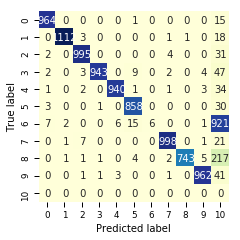

In [14]:
# plot confusion matrix
pred = digit_classifier.predict(X_test)
y_pred = to_labels(pred)
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(11),range(11))
plt.figure(figsize = (3.5,3.5))
sn.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":10})
ax = sn.heatmap(df_cm, vmin=0,vmax=1100,annot=True,cbar=False,fmt='2.0f',square=True,cmap='YlGnBu')
ax.set_xlabel('Predicted label')    
ax.set_ylabel('True label')
plt.savefig('Erase_CVAE_sparse.pdf', format='pdf')
plt.show()

In [15]:
# estimate the quality of forgetting:
# The net should correctly classify all classes but one, and it should misclasify one class
indc = (y_test!=forget_ind) # indices for correct classification
indw = (y_test==forget_ind) # indices for misclassification
num_correct = np.sum(y_test[indc]==y_pred[indc]) # number of correct predictions for remembered classes
num_wrong = np.sum(y_test[indw]!=y_pred[indw]) # number of wrong predictions for forgotten class
forget_accuracy = (num_correct+num_wrong)/y_test.size # accuracy of forgetting
print(forget_accuracy)

0.9467


The recognition of the digit is lost. However, digit still can be generated by decoder if the neuron in classifier output is excited by some specific input. Recollection by back-projections! (Accidental flashback)

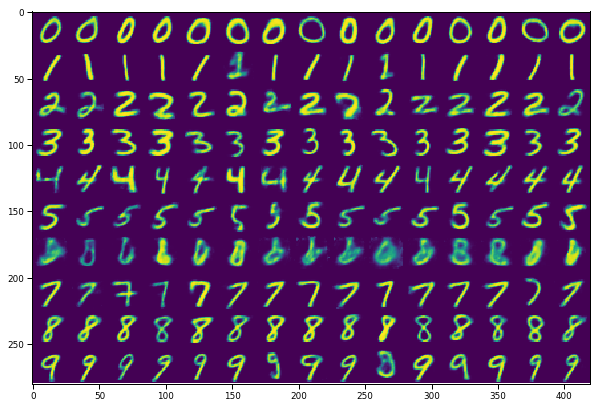

In [16]:
# display digits generated by vae with partially erased memory
nb_samp = 15  # number of digits to sample
digit_size = 28
figure = np.zeros((digit_size*10, digit_size*nb_samp))

for cl in range(10):
    ind = y_train==cl # indices of samples of proper class
    x_in = X_train[ind,:] # pick input samples of proper class
    x_in = x_in[:nb_samp,:] # limit size to several examples
    x_decoded = vae.predict(x_in)
    for samp in range(nb_samp):
        digit = x_decoded[samp,:].reshape(digit_size, digit_size)
        figure[cl*digit_size:(cl+1)*digit_size, samp*digit_size:(samp+1)*digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

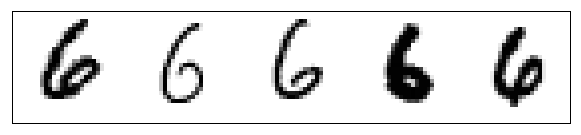

In [17]:
# display several digits of forgotten class
nb_samp = 5  # number of digits to sample
figure = np.zeros((digit_size, digit_size*nb_samp))
ind = y_train==forget_ind # indices of samples of forgotten class
x_forget = X_train[ind,:] # pick input samples of forgotten class
x_forget = x_forget[:nb_samp,:] # limit size to several examples
for samp in range(nb_samp):
    digit = x_forget[samp,:].reshape(digit_size, digit_size)
    figure[:, samp*digit_size:(samp+1)*digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(1-figure, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

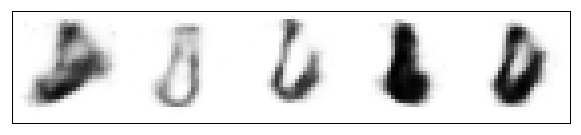

In [18]:
# display CVAE output for forgotten digits
figure = np.zeros((digit_size, digit_size*nb_samp))
x_decoded = vae.predict(x_forget) # output of VAE corresponding to forgotten class
for samp in range(nb_samp):
    digit = x_decoded[samp,:].reshape(digit_size, digit_size)
    figure[:, samp*digit_size:(samp+1)*digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(1-figure, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

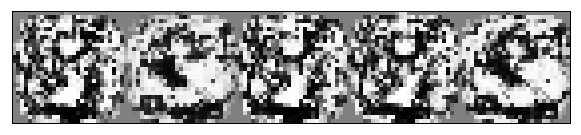

In [23]:
# display images that can induce flashback

# Freeze all the layers in classifier
for layer in digit_classifier.layers:
    layer.trainable = False

# Create network for flashback patterns production
from keras.models import Sequential
from keras import regularizers
from scipy.special import expit
from keras.optimizers import SGD

model_dream = Sequential()
model_dream.add(Dense(original_dim,input_dim=1,activation='sigmoid',
                      kernel_regularizer=regularizers.l2(0.000001),use_bias=False))
model_dream.add(digit_classifier)
#sgd = SGD(lr=0.02)
model_dream.compile(loss='binary_crossentropy',optimizer='RMSprop')

x_in = np.array([[1]])
y_out = np.expand_dims(activity[forget_ind], axis=0)
figure = np.zeros((digit_size, digit_size*nb_samp))
x_flashback = np.zeros((nb_samp,original_dim))
for samp in range(nb_samp):
    weights = np.array([[np.random.randn(original_dim)]])
    model_dream.layers[0].set_weights(weights) # initialize dream with random distribution 
    history = model_dream.fit(x_in,y_out,batch_size=1,epochs=6000,verbose=0,shuffle=False)
#     if history.history['loss'][-1]>0.9: # if did not converge, try again
#         samp = samp-1
#         continue
    x_flashback[samp,:] = expit(model_dream.layers[0].get_weights()[0]) # output of the first layer = input pattern
    digit = x_flashback[samp,:].reshape(digit_size, digit_size)
    figure[:, samp*digit_size:(samp+1)*digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(1-figure, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

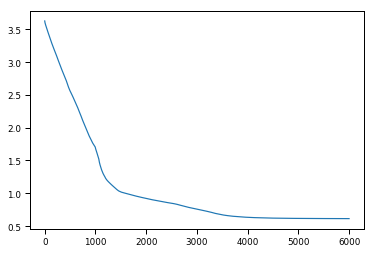

In [24]:
plt.plot(history.history['loss'])

In [25]:
digit_classifier.predict(x_flashback)

array([[1.9180017e-02, 9.8397672e-01, 1.4359765e-03, 6.1068134e-03,
        9.9083531e-01],
       [1.3678890e-03, 9.9763727e-01, 3.4770425e-04, 9.2556875e-04,
        9.9924111e-01],
       [1.1625995e-02, 9.8706079e-01, 2.9283478e-03, 7.4232626e-03,
        9.9205315e-01],
       [1.8561436e-02, 9.8131037e-01, 7.6686556e-04, 9.0316329e-03,
        9.8966825e-01],
       [8.4378000e-04, 9.9350846e-01, 1.1911483e-03, 1.0524251e-03,
        9.9714226e-01]], dtype=float32)

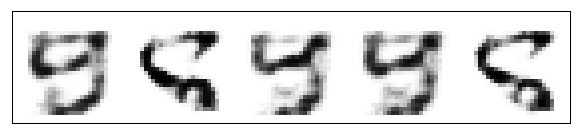

In [26]:
# display CVAE output for flashback input
figure = np.zeros((digit_size, digit_size*nb_samp))
x_recall = vae.predict(x_flashback)
for samp in range(nb_samp):
    digit = x_recall[samp,:].reshape(digit_size, digit_size)
    figure[:, samp*digit_size:(samp+1)*digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(1-figure, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

**Conclusion**: Even by inducing the correct activity in classifier, one can not reproduce forgotten digits as patterns produced by activation maximization scramble the style information